In [26]:
%pip install skimage

  Using cached skimage-0.0.tar.gz (757 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm

num_images = int(input("Enter the number of images required for pre-processing: "))
print(f"Preprocessing {num_images} from each category...")

root_path = 'asl_alphabet_train\\asl_alphabet_train'
dir_paths = os.listdir(root_path)
dir_paths.sort()

for idx, dir_path in enumerate(dir_paths):
    print(f"Processing directory: {dir_path}")
    all_images = os.listdir(os.path.join(root_path, dir_path))
    os.makedirs(f"ASL/input/preprocessed_image/{dir_path}", exist_ok=True)
    print(f"Found {len(all_images)} images in directory {dir_path}")
    for i in range(num_images):
        rand_id = random.randint(0, len(all_images) - 1)
        print(f"Processing image {i+1}/{num_images}")
        image_path = os.path.join(root_path, dir_path, all_images[rand_id])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            continue
        image = cv2.resize(image, (224, 224))
        output_path = f"ASL/input/preprocessed_image/{dir_path}/{dir_path}{i}.jpg"
        cv2.imwrite(output_path, image)
        print(f"Processed image saved at: {output_path}")

print('DONE')


Preprocessing 2000 from each category...
Processing directory: A
Found 3000 images in directory A
Processing image 1/2000
Processed image saved at: ASL/input/preprocessed_image/A/A0.jpg
Processing image 2/2000
Processed image saved at: ASL/input/preprocessed_image/A/A1.jpg
Processing image 3/2000
Processed image saved at: ASL/input/preprocessed_image/A/A2.jpg
Processing image 4/2000
Processed image saved at: ASL/input/preprocessed_image/A/A3.jpg
Processing image 5/2000
Processed image saved at: ASL/input/preprocessed_image/A/A4.jpg
Processing image 6/2000
Processed image saved at: ASL/input/preprocessed_image/A/A5.jpg
Processing image 7/2000
Processed image saved at: ASL/input/preprocessed_image/A/A6.jpg
Processing image 8/2000
Processed image saved at: ASL/input/preprocessed_image/A/A7.jpg
Processing image 9/2000
Processed image saved at: ASL/input/preprocessed_image/A/A8.jpg
Processing image 10/2000
Processed image saved at: ASL/input/preprocessed_image/A/A9.jpg
Processing image 11/2

In [28]:
%pip install imutils

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from imutils import paths

# get all the image paths
image_paths = list(paths.list_images('ASL\\input\\preprocessed_image'))

# create a DataFrame 
data = pd.DataFrame()
labels = []

for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    # save the relative path for mapping image to target
    data.loc[i, 'image_path'] = image_path
    labels.append(label)

labels = np.array(labels)

# one hot encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)

# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# save as CSV file
data.to_csv('ASL/input/data.csv', index=False)

# create output directory if it doesn't exist
output_dir = 'ASL/output/'
os.makedirs(output_dir, exist_ok=True)

# pickle the binarized labels
print('Saving the binarized labels as pickled file')
joblib.dump(lb, os.path.join(output_dir, 'lb.pkl'))

print(data.head(5))


100%|██████████| 58000/58000 [04:06<00:00, 235.62it/s]


Saving the binarized labels as pickled file
                                          image_path  target
0           ASL\input\preprocessed_image\S\S1854.jpg    18.0
1            ASL\input\preprocessed_image\C\C793.jpg     2.0
2           ASL\input\preprocessed_image\H\H1517.jpg     7.0
3  ASL\input\preprocessed_image\nothing\nothing15...    27.0
4            ASL\input\preprocessed_image\O\O681.jpg    14.0


In [30]:
import torch.nn as nn
import torch.nn.functional as F
import joblib
# load the binarized labels
print('Loading label binarizer...')
lb = joblib.load('ASL\\output\\lb.pkl')
# ### creating neural network model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, len(lb.classes_))
        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Loading label binarizer...


In [31]:
%pip install albumentations


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading label binarizer...


Computation device: cpu
Training on 49300 images
Validationg on 8700 images


  0%|          | 0/1540 [00:00<?, ?it/s]

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
277,949 total parameters.
277,949 training parameters.
Epoch 1 of 10
Training


1541it [1:12:08,  2.81s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0320, Train Acc: 67.94
Validating


272it [03:53,  1.17it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0076, Val Acc: 91.64
Epoch 2 of 10
Training


1541it [42:34,  1.66s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 96.20
Validating


272it [03:14,  1.40it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0038, Val Acc: 96.11
Epoch 3 of 10
Training


1541it [45:02,  1.75s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 98.08
Validating


272it [03:20,  1.35it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0007, Val Acc: 99.32
Epoch 4 of 10
Training


1541it [39:53,  1.55s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 98.66
Validating


272it [03:26,  1.32it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0008, Val Acc: 99.20
Epoch 5 of 10
Training


1541it [48:03,  1.87s/it]                           
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 98.61
Validating


272it [03:28,  1.30it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0002, Val Acc: 99.79
Epoch 6 of 10
Training


1541it [45:11,  1.76s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 99.18
Validating


272it [03:15,  1.39it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0009, Val Acc: 99.20
Epoch 7 of 10
Training


1541it [41:11,  1.60s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.15
Validating


272it [03:20,  1.35it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0001, Val Acc: 99.92
Epoch 8 of 10
Training


1541it [45:49,  1.78s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 99.17
Validating


272it [03:27,  1.31it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0006, Val Acc: 99.55
Epoch 9 of 10
Training


1541it [45:38,  1.78s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 99.20
Validating


272it [03:09,  1.44it/s]                         
  0%|          | 0/1540 [00:00<?, ?it/s]

Val Loss: 0.0006, Val Acc: 99.56
Epoch 10 of 10
Training


1541it [54:28,  2.12s/it]                          
  0%|          | 0/271 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 99.63
Validating


272it [04:43,  1.04s/it]                         


Val Loss: 0.0001, Val Acc: 99.93


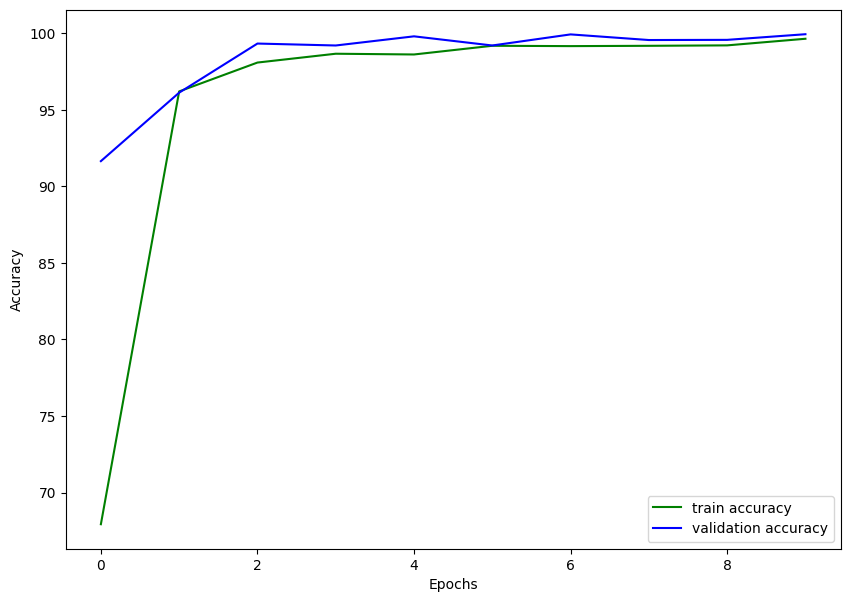

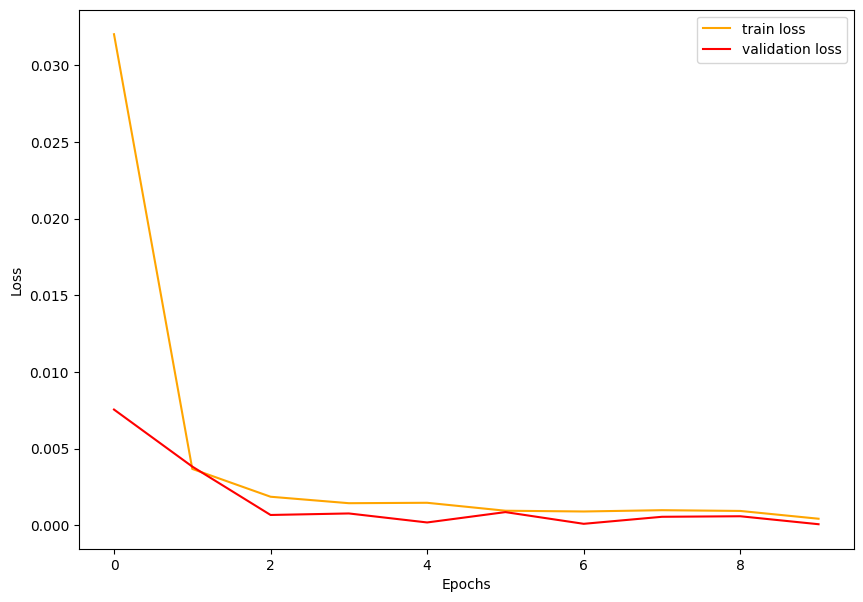

Saving model...


In [33]:
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import time
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import os
import cnn_models

# construct the argument parser and parse the arguments

num_epoch = int(input("Enter the number of epochs: "))
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 

SEED = 42
seed_everything(SEED=SEED)
''' SEED Everything '''

# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

# read the data.csv file and get the image paths and labels
df = pd.read_csv('ASL/input/data.csv')
X = df.image_path.values
y = df.target.values
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, test_size=0.15, random_state=42))
print(f"Training on {len(xtrain)} images")
print(f"Validationg on {len(xtest)} images")

# image dataset module
class ASLImageDataset(Dataset):
    def __init__(self, path, labels):
        self.X = path
        self.y = labels
        # apply augmentations
        self.aug = albumentations.Compose([
            albumentations.Resize(224, 224, always_apply=True),
        ])
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        image = cv2.imread(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

train_data = ASLImageDataset(xtrain, ytrain)
test_data = ASLImageDataset(xtest, ytest)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)

# model initialization
model = cnn_models.CustomCNN().to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()

# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    train_accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == target).sum().item()
        
        val_loss = running_loss/len(dataloader.dataset)
        val_accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} of {num_epoch}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'model.pth')


CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Model loaded
torch.Size([1, 3, 224, 224])
PREDS tensor([0])
Predicted output: A
0.159 seconds


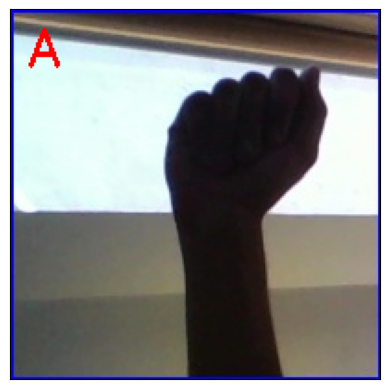

In [37]:
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2
import albumentations
import torch.nn.functional as F
import time
import cnn_models
import matplotlib.pyplot as plt

# Manually specify the path of the test image
test_img_path = input("Enter the path of the test image: ")

# Define the augmentation pipeline
aug = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
])

# Load the label binarizer
lb = joblib.load('ASL/output/lb.pkl')

# Load the model
model = cnn_models.CustomCNN()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode
print(model)
print('Model loaded')

# Read the test image
image = cv2.imread(test_img_path)
image_copy = image.copy()

# Apply the augmentation
image = aug(image=np.array(image))['image']
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = image.unsqueeze(0)
print(image.shape)

# Perform inference
start = time.time()
with torch.no_grad():
    outputs = model(image)
_, preds = torch.max(outputs, 1)
print('PREDS', preds)
print(f"Predicted output: {lb.classes_[preds]}")
end = time.time()
print(f"{(end-start):.3f} seconds")

# Display the result on the image
cv2.putText(image_copy, lb.classes_[preds], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# Show the image with prediction
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])  
plt.show()


In [1]:
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2
import torch.nn.functional as F
import time
import cnn_models
 
# load label binarizer
lb = joblib.load('ASL/output/lb.pkl')
model = cnn_models.CustomCNN()
model.load_state_dict(torch.load('model.pth'))
print(model)
print('Model loaded')

def hand_area(img):
    hand = img[100:324, 100:324]
    hand = cv2.resize(hand, (224,224))
    return hand


# In[ ]:


cap = cv2.VideoCapture(0)
if (cap.isOpened() == False):
    print('Error while trying to open camera. Plese check again...')
# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# define codec and create VideoWriter object
out = cv2.VideoWriter('ASL/output/asl.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width,frame_height))
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    # get the hand area on the video capture screen
    cv2.rectangle(frame, (100, 100), (324, 324), (20, 34, 255), 2)
    hand = hand_area(frame)
    image = hand
    
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float)
    image = image.unsqueeze(0)
    
    outputs = model(image)
    _, preds = torch.max(outputs.data, 1)
    
    cv2.putText(frame, lb.classes_[preds], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    cv2.imshow('image', frame)
    out.write(frame)
    # press `q` to exit
    if cv2.waitKey(27) & 0xFF == ord('q'):
        break
# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()

Loading label binarizer...
CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Model loaded


CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Model loaded
torch.Size([1, 3, 224, 224])
PREDS tensor([3])
Predicted output: D
0.036 seconds


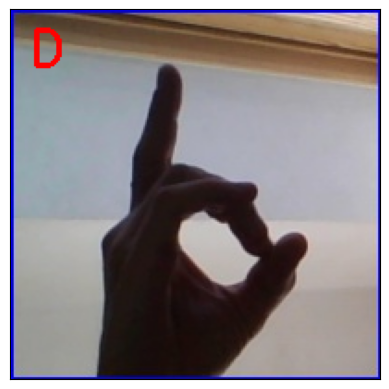

In [42]:
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2
import albumentations
import torch.nn.functional as F
import time
import cnn_models
import matplotlib.pyplot as plt

# Manually specify the path of the test image
test_img_path = input("Enter the path of the test image: ")

# Define the augmentation pipeline
aug = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
])

# Load the label binarizer
lb = joblib.load('ASL/output/lb.pkl')

# Load the model
model = cnn_models.CustomCNN()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode
print(model)
print('Model loaded')

# Read the test image
image = cv2.imread(test_img_path)
image_copy = image.copy()

# Apply the augmentation
image = aug(image=np.array(image))['image']
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = image.unsqueeze(0)
print(image.shape)

# Perform inference
start = time.time()
with torch.no_grad():
    outputs = model(image)
_, preds = torch.max(outputs, 1)
print('PREDS', preds)
print(f"Predicted output: {lb.classes_[preds]}")
end = time.time()
print(f"{(end-start):.3f} seconds")

# Display the result on the image
cv2.putText(image_copy, lb.classes_[preds], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# Show the image with prediction
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])  
plt.show()


CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Model loaded
torch.Size([1, 3, 224, 224])
PREDS tensor([23])
Predicted output: X
0.034 seconds


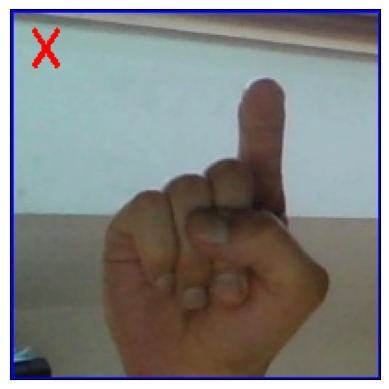

In [44]:
import torch
import joblib
import torch.nn as nn
import numpy as np
import cv2
import albumentations
import torch.nn.functional as F
import time
import cnn_models
import matplotlib.pyplot as plt

# Load the label binarizer
lb = joblib.load('ASL/output/lb.pkl')

# Load the model
model = cnn_models.CustomCNN()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode
print(model)
print('Model loaded')

# Define the augmentation pipeline
aug = albumentations.Compose([
    albumentations.Resize(224, 224, always_apply=True),
])

# Define function for sign language prediction on a single frame
def predict_sign_language_single_frame(frame):
    # Apply the augmentation
    frame = aug(image=frame)['image']
    frame = np.transpose(frame, (2, 0, 1)).astype(np.float32)
    frame = torch.tensor(frame, dtype=torch.float)
    frame = frame.unsqueeze(0)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(frame)
    _, preds = torch.max(outputs, 1)
    predicted_class = lb.classes_[preds]
    
    return predicted_class

# Define function for real-time sign language prediction from camera feed
def predict_sign_language_real_time():
    # Open camera capture
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
    
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break
        
        # Make prediction on the frame
        prediction = predict_sign_language_single_frame(frame)
        print("Predicted class:", prediction)

        # Display the result on the image
        cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Show the frame with prediction
        cv2.imshow('Sign Language Prediction', frame)
        
        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the capture
    cap.release()
    cv2.destroyAllWindows()

# Call the function to start real-time prediction
predict_sign_language_real_time()


EXPORTING THE MODEL AS PICKLE FILE 

In [3]:
import pickle
import torch

# Load the PyTorch model
model = torch.load('model.pth')

# Save the model as a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [1]:
import joblib
import pandas as pd

# Load the binarized labels from the pickled file
lb = joblib.load('ASL/output/lb.pkl')

# Convert the labels to DataFrame for visualization
labels_data = pd.DataFrame({'Class': lb.classes_})

# Display the DataFrame
print(labels_data.head())


  Class
0     A
1     B
2     C
3     D
4     E


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
import joblib
import pandas as pd

# Load the binarized labels from the pickled file
lb = joblib.load('ASL/output/lb.pkl')

# Convert the labels to DataFrame for visualization
labels_data = pd.DataFrame({'Class': lb.classes_})

# Print the entire DataFrame
print(labels_data)


      Class
0         A
1         B
2         C
3         D
4         E
5         F
6         G
7         H
8         I
9         J
10        K
11        L
12        M
13        N
14        O
15        P
16        Q
17        R
18        S
19        T
20        U
21        V
22        W
23        X
24        Y
25        Z
26      del
27  nothing
28    space


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Printing Weights 

In [3]:
import torch
import cnn_models

# Create an instance of your model
model = cnn_models.CustomCNN()

# Load the saved model weights
model.load_state_dict(torch.load('model.pth'))

# Print the weights of each layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


conv1.weight tensor([[[[ 0.1234,  0.1000, -0.0378,  0.1020, -0.0217],
          [ 0.0613, -0.0607,  0.0399,  0.0824, -0.0918],
          [ 0.1526,  0.0247,  0.0546, -0.0122,  0.0408],
          [ 0.0580,  0.1190,  0.0068, -0.0732,  0.0166],
          [ 0.0288,  0.0320, -0.0332,  0.0799, -0.0878]],

         [[-0.0571, -0.0910, -0.1967, -0.1405, -0.2760],
          [ 0.1151, -0.1515, -0.0408, -0.1310, -0.1895],
          [ 0.1150, -0.0012,  0.0021, -0.0984, -0.1438],
          [ 0.1044, -0.0071,  0.0081,  0.0350, -0.0056],
          [ 0.0381,  0.1181,  0.0234,  0.0359, -0.1043]],

         [[-0.1343, -0.1211, -0.2337, -0.0740, -0.1436],
          [ 0.0417, -0.0358, -0.1500, -0.0784, -0.2522],
          [ 0.0321, -0.1181, -0.0752, -0.1707, -0.0921],
          [ 0.0276,  0.0972, -0.1327, -0.1619, -0.1667],
          [ 0.1673,  0.0629,  0.0851, -0.1492, -0.1808]]],


        [[[-0.0956, -0.0829,  0.0415,  0.0361,  0.0907],
          [-0.0645, -0.0836,  0.0564, -0.0516,  0.0651],
          

PROTOTXT FILE FOR HAND DETECTION 

In [1]:
def generate_prototxt():
    num_classes = 26  # Number of classes (assuming 26 classes for alphabet letters)

    prototxt = f"""name: "CustomCNN"
input: "data"
input_dim: 1
input_dim: 3
input_dim: 224
input_dim: 224

layer {{
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {{
    num_output: 16
    kernel_size: 5
    stride: 1
  }}
}}
layer {{
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}}
layer {{
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {{
    pool: MAX
    kernel_size: 2
    stride: 2
  }}
}}
layer {{
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {{
    num_output: 32
    kernel_size: 5
    stride: 1
  }}
}}
layer {{
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}}
layer {{
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {{
    pool: MAX
    kernel_size: 2
    stride: 2
  }}
}}
layer {{
  name: "conv3"
  type: "Convolution"
  bottom: "pool2"
  top: "conv3"
  convolution_param {{
    num_output: 64
    kernel_size: 3
    stride: 1
  }}
}}
layer {{
  name: "relu3"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}}
layer {{
  name: "pool3"
  type: "Pooling"
  bottom: "conv3"
  top: "pool3"
  pooling_param {{
    pool: MAX
    kernel_size: 2
    stride: 2
  }}
}}
layer {{
  name: "conv4"
  type: "Convolution"
  bottom: "pool3"
  top: "conv4"
  convolution_param {{
    num_output: 128
    kernel_size: 5
    stride: 1
  }}
}}
layer {{
  name: "relu4"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}}
layer {{
  name: "pool4"
  type: "Pooling"
  bottom: "conv4"
  top: "pool4"
  pooling_param {{
    pool: MAX
    kernel_size: 2
    stride: 2
  }}
}}
layer {{
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool4"
  top: "fc1"
  inner_product_param {{
    num_output: 256
  }}
}}
layer {{
  name: "relu5"
  type: "ReLU"
  bottom: "fc1"
  top: "fc1"
}}
layer {{
  name: "fc2"
  type: "InnerProduct"
  bottom: "fc1"
  top: "fc2"
  inner_product_param {{
    num_output: {num_classes}
  }}
}}
layer {{
  name: "prob"
  type: "Softmax"
  bottom: "fc2"
  top: "prob"
}}
"""
    with open("hand_detection.prototxt", "w") as f:
        f.write(prototxt)

generate_prototxt()
